## Data Generation Tutorial 
---

This is the first tutorial to generate the dataset. 
We build a dataset using core radii between $1$\,nm and $100$\,nm and shell thickness between 1nm and 100nm. The allowed materials are the plasmonic metals gold (Au) and silver (Ag), as well as the dielectric materials  silicon (Si), silica (SiO2), silicon nitride (Si3N4), ZrO2, and TiO2. The visible light wavelength range is sampled with 64 points from 400nm to 800nm.

It has 3 parts: 
1. Define the design parameters (it will calculate the total the configuration of the core-shell nanoparticles geometries)
2. Calculate the Mie scattering and read material 
3. Loop and create dataframe and save in wide format. 

### <u> Import packages </u> 

In [1]:
import tqdm
import numpy as np
import pandas as pd
import os
import ast
import re
from joblib import Parallel, delayed, cpu_count
import pymiecs

###  Design Parameter 
---

In [2]:
core_radii = np.linspace(1, 100, 50, dtype=int)
shell_thicknesses = np.linspace(1, 100, 50, dtype=int)

N_materials = 7  # Si, SiO2, Au, Ag, Si3N4, ZrO2, TiO2

# Total number of unique configurations including material choices for the core and each shell
C_material = len(core_radii) * len(shell_thicknesses) * (N_materials**2)

print(f" Total configuration: {C_material}")

 Total configuration: 122500


### Function to calculate scattering efficiency
--- 

In [3]:
# %% --- Mie
def get_Mie_spec(wavelengths, r_core, r_shell, mat_core, mat_shell, n_env):

    k0 = 2 * np.pi / wavelengths
    n_core = mat_core.get_refindex(wavelengths)
    n_shell = mat_shell.get_refindex(wavelengths)

    res = pymiecs.Q(
        k0,
        r_core=r_core,
        n_core=n_core,
        r_shell=r_shell,
        n_shell=n_shell,
        n_env=n_env.real**0.5,  # host medium must be lossless
    )
    return (
        res["qsca"],
        res["qback"],
        res["qfwd"],
    )

### Configuration to data frame 

In [4]:
# available materials
Si = pymiecs.materials.MaterialDatabase("Si")
SiO2 = pymiecs.materials.MaterialDatabase("SiO2")
Si3N4 = pymiecs.materials.MaterialDatabase("Si3N4")
Au = pymiecs.materials.MaterialDatabase("Au")
Ag = pymiecs.materials.MaterialDatabase("Ag")
ZrO2 = pymiecs.materials.MaterialDatabase("ZrO2")
TiO2 = pymiecs.materials.MaterialDatabase("TiO2")

material_keys = {
    "Si": Si,
    "SiO2": SiO2,
    "Au": Au,
    "Ag": Ag,
    "Si3N4": Si3N4,
    "ZrO2": ZrO2,
    "TiO2": TiO2,
}


# Wavelength range for the scattering efficiency
wavelengths = np.linspace(400, 800, 64)  # From 400 nm to 800 nm with 64 points
n_env = 1.0

###  Configuration to data frame 
---
The code cell below take sometimes to run. 


In [5]:
# save file name
hdf5_file_name = "datasets/core_shell_particles_raw_122500.h5"

# Prepare to store the results
results = []
configs = []
configs_matkeys = []
# generate all configurations
for idx in tqdm.tqdm(range(len(core_radii)), desc="generate configurations..."):
    r_core = core_radii[idx]
    for t_shell in shell_thicknesses:
        r_shell = r_core + t_shell

        # create all material permutations
        configs += [
            (r_core, r_shell, material_keys[m_c_key], material_keys[m_s_key])
            for m_c_key in material_keys
            for m_s_key in material_keys
        ]

        # keep also material keys for database
        configs_matkeys += [
            (m_c_key, m_s_key) for m_c_key in material_keys for m_s_key in material_keys
        ]


# multiprocessing call function
def call_mie(r_core, r_shell, mat_core, mat_shell):
    return get_Mie_spec(
        wavelengths=wavelengths,
        r_core=r_core,
        r_shell=r_shell,
        mat_core=mat_core,
        mat_shell=mat_shell,
        n_env=n_env,
    )


# run all configs in multiprocessing
parallel = Parallel(n_jobs=cpu_count() // 2)  # physical cores
out = parallel(
    delayed(call_mie)(*conf)
    for conf in tqdm.tqdm(configs, desc="parallel Mie evaluation...")
)


# save all configs
all_results_as_list_of_dicts = []
for i_conf in tqdm.tqdm(range(len(out)), desc="gather results..."):
    _res = out[i_conf]
    r_c = configs[i_conf][0]
    r_s = configs[i_conf][1]
    t_s = r_s - r_c
    Qscat, Qback, Qfwd = _res
    sample = {
        "mat_core": configs_matkeys[i_conf][0],
        "mat_shell": configs_matkeys[i_conf][1],
        "r_core": r_c,
        "r_shell": r_s,
        "wavelength": wavelengths,
        "Q_sca": Qscat,
        "Q_back": Qback,
        "Q_fwd": Qfwd,
    }
    all_results_as_list_of_dicts.append(sample)


# print save pandas dataframe to hdf5
results_pd = pd.DataFrame.from_dict(all_results_as_list_of_dicts)
results_pd.to_hdf(hdf5_file_name, key="all_configurations", mode="w")

results_pd.head()

gather results...: 100%|██████████| 122500/122500 [00:00<00:00, 907641.50it/s]
/tmp/ipykernel_2770455/4266422180.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['mat_core', 'mat_shell', 'wavelength', 'Q_sca', 'Q_back', 'Q_fwd'], dtype='object')]

  results_pd.to_hdf(hdf5_file_name, key="all_configurations", mode="w")


,mat_core,mat_shell,r_core,r_shell,wavelength,Q_sca,Q_back,Q_fwd
0,Si,Si,1,2,"[400.0, 406.3492063492063, 412.6984126984127, ...","[2.160839086497138e-06, 2.0034967444389096e-06...","[3.2335562550935324e-06, 2.998696933738638e-06...","[3.2489628896450263e-06, 3.0117948478578205e-0..."
1,Si,SiO2,1,2,"[400.0, 406.3492063492063, 412.6984126984127, ...","[3.9143528694988674e-07, 3.6438451909391744e-0...","[5.868605004574553e-07, 5.463176494864905e-07,...","[5.874454060091694e-07, 5.468359469672794e-07,..."
2,Si,Au,1,2,"[400.0, 406.3492063492063, 412.6984126984127, ...","[2.6613881597578463e-06, 2.482639350607367e-06...","[3.991253362741106e-06, 3.7232254787413343e-06...","[3.992911163065486e-06, 3.724692610081798e-06,..."
3,Si,Ag,1,2,"[400.0, 406.3492063492063, 412.6984126984127, ...","[6.066105540702947e-06, 5.130173539793614e-06,...","[9.09914972315353e-06, 7.695458555236092e-06, ...","[9.099166460968062e-06, 7.69506165808914e-06, ..."
4,Si,Si3N4,1,2,"[400.0, 406.3492063492063, 412.6984126984127, ...","[9.57380852593803e-07, 8.912867496023801e-07, ...","[1.4351768921144704e-06, 1.3361307534275844e-0...","[1.4369658329245613e-06, 1.3377296403994528e-0..."


### Verification: Plot some random sample

test sample # 81159: 
core / shell radii: 67 80
core / shell mat.: Au SiO2
test sample # 39788: 
core / shell radii: 33 58
core / shell mat.: Si Si
test sample # 92579: 
core / shell radii: 75 154
core / shell mat.: Au Si3N4
test sample # 82126: 
core / shell radii: 67 120
core / shell mat.: Si Au


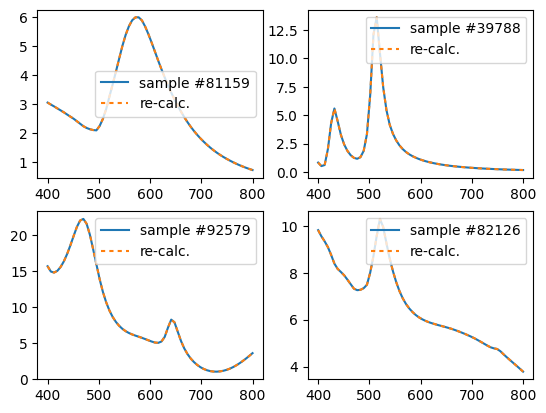

In [6]:
import matplotlib.pyplot as plt


for i in range(4):
    idx_test = np.random.randint(len(results_pd["r_core"]))

    print("test sample # {}: ".format(idx_test))
    print(
        "core / shell radii:",
        results_pd["r_core"][idx_test],
        results_pd["r_shell"][idx_test],
    )
    print(
        "core / shell mat.:",
        results_pd["mat_core"][idx_test],
        results_pd["mat_shell"][idx_test],
    )

    # - recalculate for comparison
    recalc_spec = get_Mie_spec(
        results_pd["wavelength"][idx_test],
        results_pd["r_core"][idx_test],
        results_pd["r_shell"][idx_test],
        material_keys[results_pd["mat_core"][idx_test]],
        material_keys[results_pd["mat_shell"][idx_test]],
        n_env,
    )
    plt.subplot(2, 2, i + 1)
    plt.plot(
        results_pd["wavelength"][idx_test],
        results_pd["Q_fwd"][idx_test],
        label=f"sample #{idx_test}",
    )
    plt.plot(
        results_pd["wavelength"][idx_test],
        recalc_spec[2],
        label="re-calc.",
        dashes=[2, 2],
    )
    plt.legend()
plt.show()